<a href="https://colab.research.google.com/github/AdriaDelhom/CGM/blob/main/ACC_highpass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I just wanted to experiment with various ways of removing gravity  from the accelerometer data, building on Noah's code:

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/CGM/data')

Mounted at /content/drive


In [ ]:
ACC_HZ = 32
ACC_G_MODE = 2
SMALL_G = 9.81

In [ ]:
class Patient:

  metric_map = {
      'acc': 'ACC',
      'bvp': 'BVP',
      'glu': 'Dexcom',
      'eda': 'EDA',
      'food': 'Food_Log',
      'hr': 'HR',
      'ibi': 'IBI',
      'temp': 'TEMP'
  }

  def __init__(self, patient_id, gender, hba1c) -> None:
    self.patient_id: int = patient_id
    self.gender: str = gender
    self.hba1c: float = hba1c

    self._acc: pd.DataFrame = None
    self._bvp: pd.DataFrame = None
    self._glu: pd.DataFrame = None
    self._eda: pd.DataFrame = None
    self._food: pd.DataFrame = None
    self._hr: pd.DataFrame = None
    self._ibi: pd.DataFrame = None
    self._temp: pd.DataFrame = None


  def get_file_path(self, metric):
    metric_name = Patient.metric_map[metric]
    return f'./{self.patient_id:03d}/{metric_name}_{self.patient_id:03d}.csv'

  @property
  def acc(self):
    if self._acc is None:
      self._acc = pd.read_csv(self.get_file_path('acc'), index_col=['datetime'],
                              parse_dates=['datetime'], engine='pyarrow')
      self._acc.columns = [c.strip() for c in self._acc.columns]
      # Convert all columns to m/s^2 from int8 in 2G mode
      # TODO It is possible that values <0 should be divided by 128 and > 0 by 127
      self._acc['acc_x'] = (self._acc['acc_x'] * ACC_G_MODE * SMALL_G) / 127
      self._acc['acc_y'] = (self._acc['acc_y'] * ACC_G_MODE * SMALL_G) / 127
      self._acc['acc_z'] = (self._acc['acc_z'] * ACC_G_MODE * SMALL_G) / 127
    return self._acc

  @property
  def bvp(self):
    if self._bvp is None:
      self._bvp = pd.read_csv(self.get_file_path('bvp'), index_col=['datetime'],
                              parse_dates=['datetime'], engine='pyarrow')
      self._bvp.columns = [c.strip() for c in self._bvp.columns]
    return self._bvp


  @property
  def glu(self):
    if self._glu is None:
      self._glu = pd.read_csv(self.get_file_path('glu'), header=0,
                              skiprows=range(1, 13),
                              index_col=['Timestamp (YYYY-MM-DDThh:mm:ss)'],
                              parse_dates=['Timestamp (YYYY-MM-DDThh:mm:ss)'])
      self._glu = self._glu.rename(columns={'Glucose Value (mg/dL)': 'glucose'})
      self._glu = self._glu.rename_axis('datetime')
      self._glu = self._glu[['glucose']]
    return self._glu

  @property
  def eda(self):
    if self._eda is None:
      self._eda = pd.read_csv(self.get_file_path('eda'), index_col=['datetime'],
                              parse_dates=['datetime'], engine='pyarrow')
      self._eda.columns = [c.strip() for c in self._eda.columns]
    return self._eda

  @property
  def food(self):
    if self._food is None:
      if self.patient_id == 3:
        # Patient 3 has no header
        self._food = pd.read_csv(self.get_file_path('food'), skipinitialspace=True)
        self._food.columns = ['date', 'time', 'time_begin', 'logged_food', 'amount', 'unit', 'searched_food', 'calorie', 'total_carb', 'sugar', 'protein']
        self._food['time_begin'] = pd.to_datetime(self._food['time_begin'])
        self._food['time_end'] = None
        self._food = self._food.set_index('time_begin')
      else:
        self._food = pd.read_csv(self.get_file_path('food'), index_col=['time_begin'], parse_dates=['time_begin'], skipinitialspace=True)

      self._food['time_end'] = pd.to_datetime(self._food['date'] + ' ' + self._food['time_end'])

      end_times = self._food.groupby('time_begin')['time_end'].min()
      self._food = self._food.merge(end_times, how='left', on='time_begin', suffixes=('','_x'), validate='many_to_one')
      self._food['time_end'] = self._food['time_end'].fillna(self._food['time_end_x'])
      self._food = self._food.drop('time_end_x', axis=1)

      # Fill in NaN in searched food with empty string
      self._food['searched_food'] = self._food['searched_food'].fillna('')

      # Some food logs have `time_of_day` instead of `time`
      if self.patient_id in [7, 13, 15, 16]:
        self._food = self._food.drop(['date', 'time_of_day'], axis=1)
      else:
        self._food = self._food.drop(['date', 'time'], axis=1)
    return self._food

  @property
  def hr(self):
    if self._hr is None:
      # Patient 1 has no seconds recorded
      if self.patient_id == 1:
        self._hr = pd.read_csv('./001/HR_001.csv',
                              parse_dates=['datetime'],
                              date_format='%m/%d/%y %H:%M',
                              engine='pyarrow')
        self._hr.loc[self._hr.groupby('datetime').cumcount() + 1 != 1, 'datetime'] = pd.NaT
        self._hr = self._hr.interpolate(method='linear')
        self._hr = self._hr.set_index('datetime')
      else:
        self._hr = pd.read_csv(self.get_file_path('hr'), index_col=['datetime'],
                              parse_dates=['datetime'], engine='pyarrow')
      self._hr.columns = [c.strip() for c in self._hr.columns]

    return self._hr

  @property
  def ibi(self):
    if self._ibi is None:
      self._ibi = pd.read_csv(self.get_file_path('ibi'), index_col=['datetime'],
                              parse_dates=['datetime'], engine='pyarrow')
      self._ibi.columns = [c.strip() for c in self._ibi.columns]
    return self._ibi

  @property
  def temp(self):
    if self._temp is None:
      self._temp = pd.read_csv(self.get_file_path('temp'), index_col=['datetime'],
                              parse_dates=['datetime'], engine='pyarrow')
      self._temp.columns = [c.strip() for c in self._temp.columns]
    return self._temp

class CGMData:
  patients: Patient = {}
  demographics: pd.DataFrame = None

  def __init__(self) -> None:
    self.demographics = pd.read_csv('./Demographics.csv', index_col='ID')

  def __getitem__(self, key):
    if key < 1 or key > 16:
      raise IndexError(f'Patient ID {key} out of range')
    if key not in self.patients:
      patient_demo = self.demographics.loc[key]
      self.patients[key] = Patient(key, patient_demo['Gender'], patient_demo['HbA1c'])
    return self.patients[key]

In [ ]:
data = CGMData()
print(data[1].gender)
print(data[1].hba1c)
# print(data[1].glu.head(5))

FEMALE
5.5


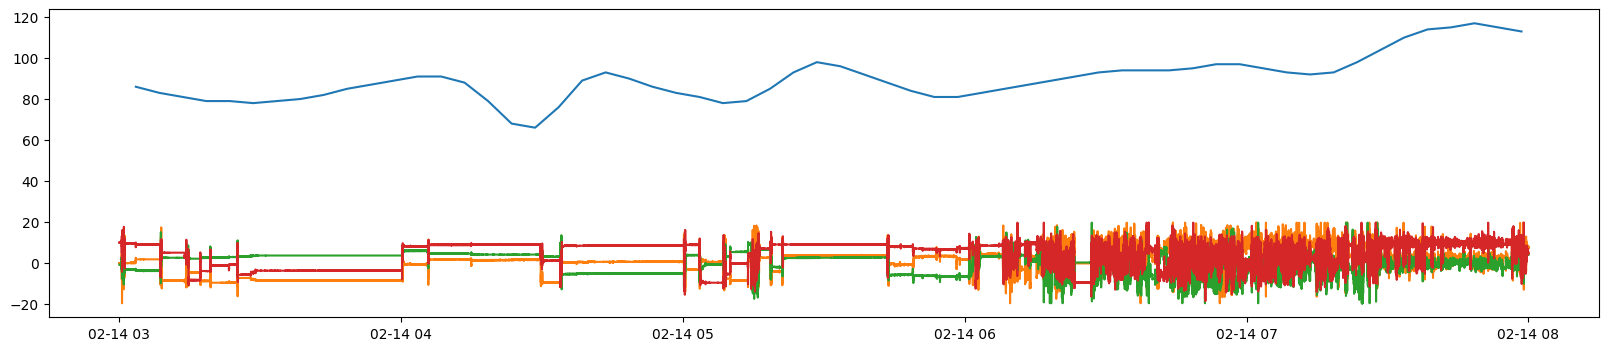

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(data[1].glu[(data[1].glu.index < '2020-02-14 08:00:00') & (data[1].glu.index > '2020-02-14 03:00:00')])
plt.plot(data[1].acc[(data[1].acc.index < '2020-02-14 08:00:00') & (data[1].acc.index > '2020-02-14 03:00:00')])

# Experiments

Experimenting with the recursive high-pass filter suggested online:

In [ ]:
def acc_high_pass(acc, cutoff_freq, time_start, time_end): #high pass filter to remove gravity
  x = np.exp(-2*np.pi*cutoff_freq/ACC_HZ) #cutoff_freq in terms of number of samples
  a_0, b_1 = (1+x)/2, x #ref: https://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_Ch19.pdf
  acc_slice = acc.loc[time_start:time_end]
  res = acc_slice.copy()
  for col in res:
    res[col] = res[col].shift(1)
    res[col][0] = res[col][1]
    res[col] = a_0*(res[col] - acc_slice[col])
    for i in range(1,len(res)):
      res[col][i] = res[col][i] + x*res[col][i-1]
    print(col + ' done')
  return res


In [ ]:
cutoff_freq = 0.5 #Hz, i.e. one arm swing in two seconds
res = acc_high_pass(data[1].acc, cutoff_freq, '2020-02-14 05:30:00','2020-02-14 06:30:00')

acc_x done
acc_y done
acc_z done


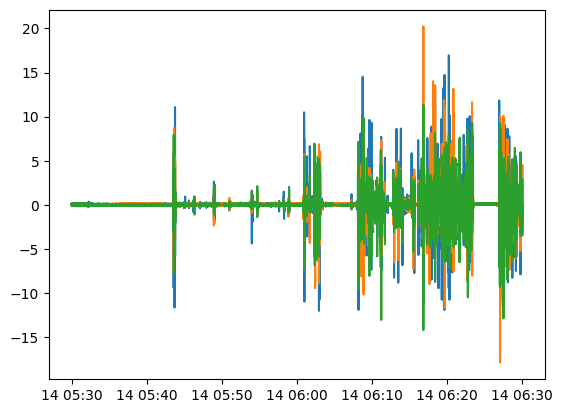

In [ ]:
plt.plot(res)

This seems to clearly show with the rest-to-movement transition seen in Noah's plot.

Still, this took slightly too long, so let's experiment with scipy's butterworth filter:

In [ ]:
from scipy.signal import butter, filtfilt
def acc_high_pass_alt(acc, cutoff_freq, time_start, time_end):
  acc_slice = acc.loc[time_start:time_end]
  res = acc_slice.copy()
  order = 4
  b, a = butter(4, 2 * cutoff_freq / ACC_HZ, btype = 'high')
  for col in res:
    res[col] = filtfilt(b, a, acc_slice[col])
  return res

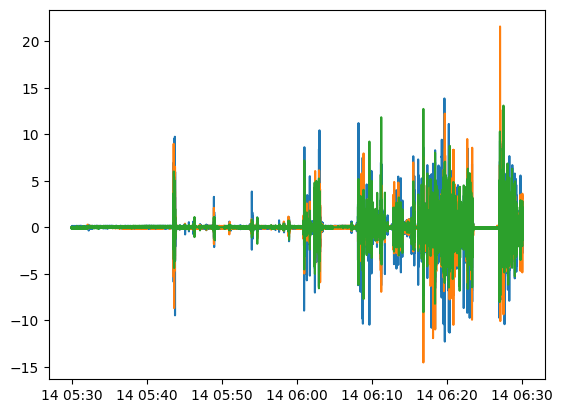

In [ ]:
res = acc_high_pass_alt(data[1].acc, cutoff_freq, '2020-02-14 05:30:00','2020-02-14 06:30:00')
plt.plot(res)

Seems to work qualitatively identically but so much faster. From 3 am to 8 am :

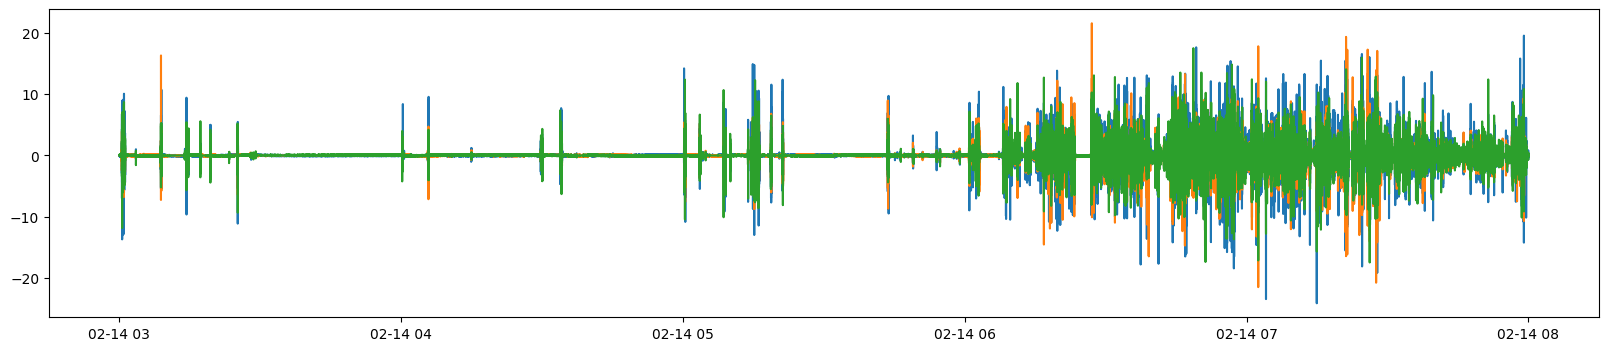

In [ ]:
res = acc_high_pass_alt(data[1].acc, cutoff_freq, '2020-02-14 03:00:00','2020-02-14 08:00:00')
plt.figure(figsize=(20, 4))
plt.plot(res)

Seems like this is the way to go!